# This notebook is for optimizing the pipeline hyperparameters

## Imports

### Basic imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns

## Functions for storing the data

In [2]:
def pickle_dump(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

def pickle_load(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

## Gathering the data and putting it into tables

In [30]:
def get_total_accuracy_bayesian():
    table = {}
    j = 0
    fs_methods = ['fs', 'none']
    fp_methods = ['fast_ica', 'pca', 'no_preprocessing']
    minutes_run = [5, 15, 30, 60]
    for fs_method in fs_methods:
        for fp_method in fp_methods:
            for minutes in minutes_run:
                if fs_method == 'fs':
                    fname = f'./data/bayesian_fs/accuracy_{minutes}_minutes_{fp_method}.pkl'
                else:
                    fname = f'./data/bayesian/accuracy_{minutes}_minutes_{fp_method}.pkl'

                automl_results = pickle_load(fname)
                for i, run_info in enumerate(automl_results['params']):
                    row = {}
                    classifier = run_info['classifier:__choice__']
                    if  classifier == 'liblinear_svc':
                        classifier = 'logistic_regression'
                    row['Classifier'] = classifier
                    row['Accuracy Score'] = automl_results['mean_test_score'][i]
                    row['Extra Increment'] = minutes
                    row['Feature Preprocessing'] = fp_method
                    row['Feature Selection'] = fs_method
                    row['HPO Method'] = 'Bayesian Optimization'
                    table[j] = row
                    j+=1
    tab = pd.DataFrame.from_dict(table).T
    # Removing crashed or unfinished runs
    return tab.loc[tab['Accuracy Score'] > 0]

In [31]:
## Average the classifiers
def get_total_accuracy_rs():
    table = {}
    j = 0
    classifier_reordered_names = ['random_forest', 'decision_tree', 'logistic_regression',
                                  'k_nearest_neighbors', 'gradient_boosting']
    fs_methods = ['fs', 'none']
    fp_methods = ['fast_ica', 'pca', 'no_preprocessing']
    numbers_grid = [5, 15, 50, 100]
    for fs_method in fs_methods:
        for fp_method in fp_methods:
            for number_grid in numbers_grid:
                if fs_method == 'fs':
                    fname = f'./data/rs_fs/accuracy_{number_grid}_numgrid_{fp_method}.pkl'
                else:
                    fname = f'./data/rs/accuracy_{number_grid}_numgrid_{fp_method}.pkl'

                randomized_search_acc = pickle_load(fname)
                for classifier in classifier_reordered_names:
                    mean_acc_score = np.mean(randomized_search_acc[classifier])
                    row = {}
                    row['Classifier'] = classifier
                    row['Accuracy Score'] = mean_acc_score
                    row['Extra Increment'] = number_grid
                    row['Feature Preprocessing'] = fp_method
                    row['Feature Selection'] = fs_method
                    row['HPO Method'] = 'Random Search'
                    table[j] = row 
                    j+= 1

                ## Keep for future work with possible variance
                    # for accuracy_scores in randomized_search_acc[classifier]:
                    #     row = {}
                    #     row['Accuracy Score'] = accuracy_scores
                    #     row['Classifier'] = classifier
                    #     row['Numbers in Grid'] = number_grid
                    #     row['Feature Preprocessing'] = fp_method
                    #     row['Feature Selection'] = fs_method
                    #     row['Associated Mean Accuracy'] = mean_acc_score
                    #     table[j] = row 
                    #     j+= 1
    return pd.DataFrame.from_dict(table).T

## Make the results into two tables

In [32]:
bayesian_tab = get_total_accuracy_bayesian()
rs_tab = get_total_accuracy_rs()
all_data_df = pd.concat([bayesian_tab, rs_tab])

## Plot comparing the two hpo methods

In [125]:
def boxplot_hpo(all_data_df, ax = None):
    if ax:
        sns.boxplot(ax = ax, x=all_data_df['HPO Method'], y = all_data_df['Accuracy Score']).set(ylabel = None)
        ax.set_xticklabels(['Bayesian', 'Random Search'], rotation=45)
    else:
        sns.boxplot(x=all_data_df['HPO Method'], y = all_data_df['Accuracy Score'])
        # plt.xticks(rotation=45)
    # plt.savefig("figures/boxplot_hpo", bbox_inches = "tight")  
    return 
# boxplot_hpo(all_data_df)

## Boxplot of Classifiers 

In [120]:
def boxplot_classifiers(all_data_df, ax = None):
    if ax:
        sns.boxplot(ax = ax, x=all_data_df['Classifier'], y = all_data_df['Accuracy Score']).set(ylabel = None)
        ax.set_xticklabels(['Random Forest', 'Decision Tree', 'Gradient Boosting', 'k-Nearest Neighbors', 'Logistic'],rotation=60)
    else:
        sns.boxplot(x=all_data_df['Classifier'], y = all_data_df['Accuracy Score'])
        plt.xticks(rotation=45)
    # plt.savefig("figures/boxplot_classifiers", bbox_inches = "tight")  
    return 
# boxplot_classifiers(all_data_df)

## Boxplot of feature preprocessors

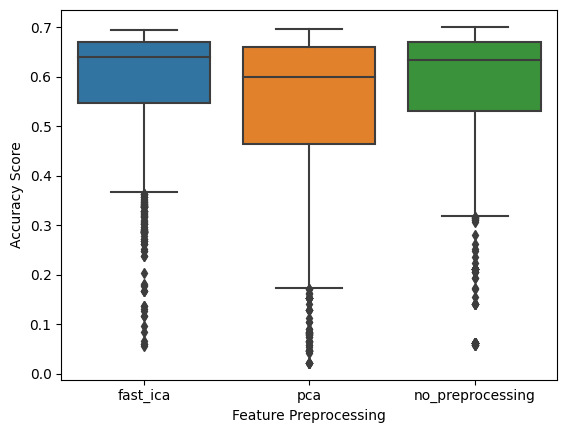

In [184]:
def boxplot_fp(all_data_df, ax = None):
    if ax:
        sns.boxplot(ax = ax, x=all_data_df['Feature Preprocessing'], y = all_data_df['Accuracy Score']).set(ylabel = None)
        ax.set_xticklabels(['Fast ICA', 'PCA', 'None'])
    else:
        sns.boxplot(x=all_data_df['Feature Preprocessing'], y = all_data_df['Accuracy Score'])
    plt.savefig("figures/boxplot_fp", bbox_inches = "tight")  
    return 
boxplot_fp(all_data_df)

## Boxplot of feature selection

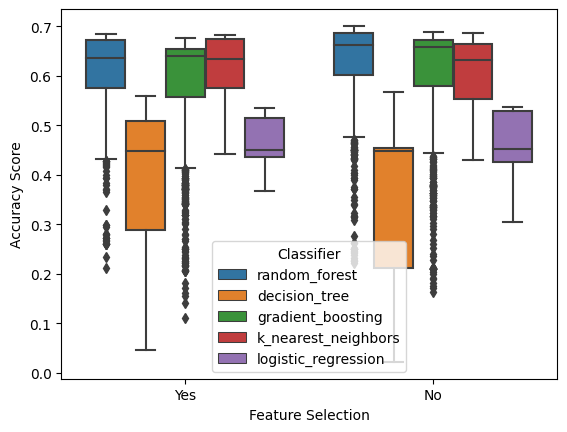

In [182]:
def boxplot_fs(all_data_df, ax = None):
    if ax:
        sns.boxplot(ax = ax, x=all_data_df['Feature Selection'], y = all_data_df['Accuracy Score']).set(ylabel = None)
        ax.set_xticklabels(['Yes', 'No'])
    else:
        sns.boxplot(x=all_data_df['Feature Selection'], y = all_data_df['Accuracy Score'], hue = all_data_df['Classifier'])\
            .set(xticklabels = ['Yes', 'No'])
    plt.savefig("figures/boxplot_fs", bbox_inches = "tight")  
    return 
boxplot_fs(all_data_df)

## Boxplots of hyperparameter settings

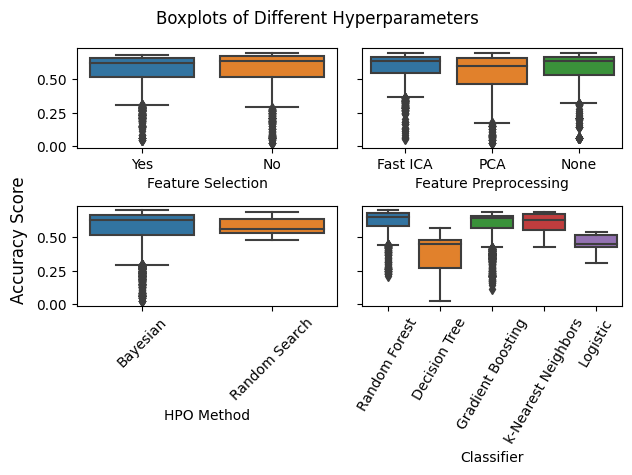

In [123]:
def boxplot_all(all_data_df):
    fig, axs = plt.subplots(2,2,sharey='all', tight_layout = True)
    fig.supylabel('Accuracy Score')
    fig.suptitle('Boxplots of Different Hyperparameters')
    axes = axs.flatten()
    boxplot_fs(all_data_df, axes[0])
    boxplot_fp(all_data_df, axes[1])
    boxplot_hpo(all_data_df, axes[2])
    boxplot_classifiers(all_data_df, axes[3])
    plt.savefig("figures/boxplot_all", bbox_inches = "tight")  
    return 
boxplot_all(all_data_df)

## Showing how increasing the additional increment parameter affects the values

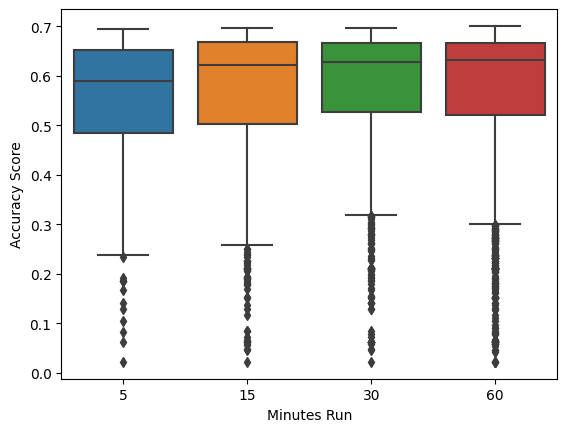

In [132]:
def boxplot_increment_bayesian(bayesian_tab):
    sns.boxplot(x = bayesian_tab['Extra Increment'], y = bayesian_tab['Accuracy Score']).set(xlabel = "Minutes Run")
    # plt.savefig("figures/boxplot_increment_bayesian", bbox_inches = "tight")  
    return 
# boxplot_increment_bayesian(bayesian_tab)

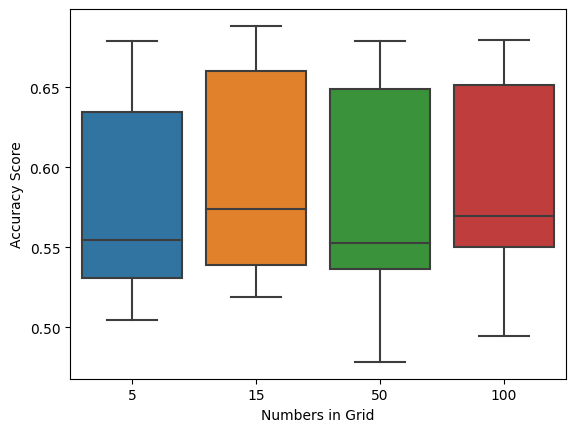

In [131]:
def boxplot_increment_rs(rs_tab):
    sns.boxplot(x = rs_tab['Extra Increment'], y = rs_tab['Accuracy Score']).set(xlabel = "Numbers in Grid")
    # plt.savefig("figures/boxplot_increment_rs", bbox_inches = "tight")  
    return 
# boxplot_increment_rs(rs_tab)

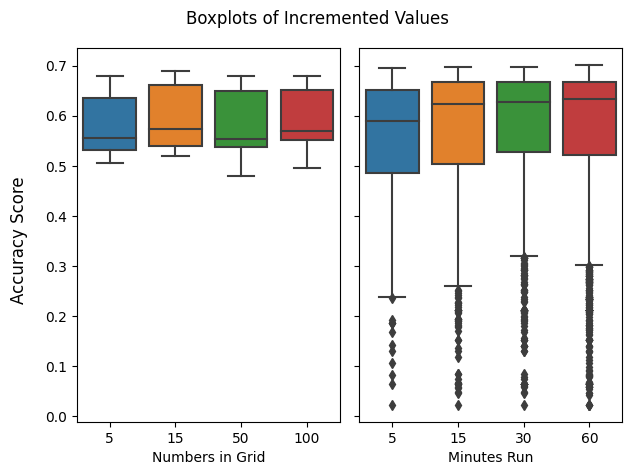

In [155]:
def boxplot_increments(rs_tab, bayesian_tab):
    fig, axs = plt.subplots(1,2,sharey='all', tight_layout = True)
    axes = axs.flatten()
    sns.boxplot(ax = axes[0], x = rs_tab['Extra Increment'], y = rs_tab['Accuracy Score']).set(xlabel = "Numbers in Grid", ylabel = None)
    sns.boxplot(ax=axes[1], x= bayesian_tab['Extra Increment'], y = bayesian_tab['Accuracy Score']).set(xlabel = "Minutes Run", ylabel = None)

    
    fig.supylabel('Accuracy Score')
    fig.suptitle('Boxplots of Incremented Values')
    plt.savefig("figures/boxplot_increments", bbox_inches = "tight")  
    return 
boxplot_increments(rs_tab, bayesian_tab)

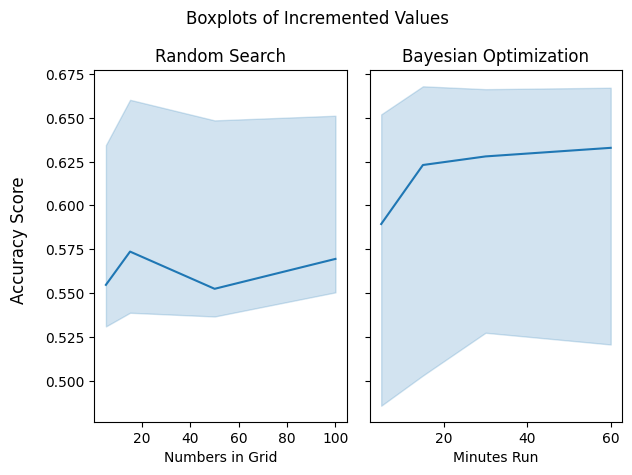

In [197]:
def lineplot_quartiles(rs_tab, bayesian_tab):
    fig, axs = plt.subplots(1,2,sharey='all', tight_layout = True)
    axes = axs.flatten()

    xlabels = ['Numbers in Grid', 'Minutes Run']
    titles = ['Random Search', 'Bayesian Optimization']
    for i, data in enumerate([rs_tab, bayesian_tab]):
        sns.lineplot(data = data, x = 'Extra Increment', y = 'Accuracy Score', estimator=np.median, ax = axes[i],
                 errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75))).set(ylabel= None, xlabel = xlabels[i], title=titles[i])

    fig.supylabel('Accuracy Score')
    fig.suptitle('Boxplots of Incremented Values')
    plt.savefig("figures/lineplot_quartiles", bbox_inches = "tight")  
lineplot_quartiles(rs_tab, bayesian_tab)

## Getting the best overall accuracy score

In [164]:
def get_best_overall(all_data_df):
    best_result = all_data_df[all_data_df['Accuracy Score'] == np.max(all_data_df['Accuracy Score'])]
    return best_result
get_best_overall(all_data_df)

,Classifier,Accuracy Score,Extra Increment,Feature Preprocessing,Feature Selection,HPO Method
6400,random_forest,0.701102,60,no_preprocessing,none,Bayesian Optimization


In [170]:
def get_best_overall_fs(all_data_df):
    all_data_fs = all_data_df[all_data_df['Feature Selection'] == 'fs']
    best_result = all_data_fs[all_data_fs['Accuracy Score'] == np.max(all_data_fs['Accuracy Score'])]
    return best_result
get_best_overall_fs(all_data_df)

,Classifier,Accuracy Score,Extra Increment,Feature Preprocessing,Feature Selection,HPO Method
1067,random_forest,0.685586,60,fast_ica,fs,Bayesian Optimization
3368,random_forest,0.685586,60,no_preprocessing,fs,Bayesian Optimization


In [167]:
def get_best_scores_hyperparameters(automl_results):
    i = np.argmin(automl_results['rank_test_scores'])
    accuracy_score = automl_results['mean_test_score'][i]
    new_dict = automl_results['params'][i]
    new_dict['accuracy'] = accuracy_score
    return new_dict
get_best_scores_hyperparameters(pickle_load('./data/bayesian/accuracy_60_minutes_no_preprocessing.pkl'))

{'balancing:strategy': 'weighting',
 'classifier:__choice__': 'random_forest',
 'data_preprocessor:__choice__': 'feature_type',
 'feature_preprocessor:__choice__': 'no_preprocessing',
 'classifier:random_forest:bootstrap': 'False',
 'classifier:random_forest:criterion': 'entropy',
 'classifier:random_forest:max_depth': 'None',
 'classifier:random_forest:max_features': 0.2569302574086536,
 'classifier:random_forest:max_leaf_nodes': 'None',
 'classifier:random_forest:min_impurity_decrease': 0.0,
 'classifier:random_forest:min_samples_leaf': 1,
 'classifier:random_forest:min_samples_split': 4,
 'classifier:random_forest:min_weight_fraction_leaf': 0.0,
 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'quantile_transformer',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:quantile_transformer:n_quantiles': 654,
 'data_preprocessor:feature_type:numerical_transfor

In [172]:
get_best_scores_hyperparameters(pickle_load('./data/bayesian_fs/accuracy_60_minutes_fast_ica.pkl'))

{'balancing:strategy': 'weighting',
 'classifier:__choice__': 'random_forest',
 'data_preprocessor:__choice__': 'feature_type',
 'feature_preprocessor:__choice__': 'fast_ica',
 'classifier:random_forest:bootstrap': 'True',
 'classifier:random_forest:criterion': 'entropy',
 'classifier:random_forest:max_depth': 'None',
 'classifier:random_forest:max_features': 0.4452896100651442,
 'classifier:random_forest:max_leaf_nodes': 'None',
 'classifier:random_forest:min_impurity_decrease': 0.0,
 'classifier:random_forest:min_samples_leaf': 1,
 'classifier:random_forest:min_samples_split': 3,
 'classifier:random_forest:min_weight_fraction_leaf': 0.0,
 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'none',
 'feature_preprocessor:fast_ica:algorithm': 'deflation',
 'feature_preprocessor:fast_ica:fun': 'cube',
 'feature_preprocessor:fast_ica:whiten': 'True',
 'feature_preprocessor:fast

In [173]:
get_best_scores_hyperparameters(pickle_load('./data/bayesian_fs/accuracy_60_minutes_no_preprocessing.pkl'))

{'balancing:strategy': 'weighting',
 'classifier:__choice__': 'random_forest',
 'data_preprocessor:__choice__': 'feature_type',
 'feature_preprocessor:__choice__': 'no_preprocessing',
 'classifier:random_forest:bootstrap': 'True',
 'classifier:random_forest:criterion': 'gini',
 'classifier:random_forest:max_depth': 'None',
 'classifier:random_forest:max_features': 0.1352518520554975,
 'classifier:random_forest:max_leaf_nodes': 'None',
 'classifier:random_forest:min_impurity_decrease': 0.0,
 'classifier:random_forest:min_samples_leaf': 1,
 'classifier:random_forest:min_samples_split': 3,
 'classifier:random_forest:min_weight_fraction_leaf': 0.0,
 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'robust_scaler',
 'data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max': 0.7117941539913081,
 'data_preprocessor:feature_type:numerical_transformer:resca

In [194]:
rs_data_fs = rs_tab[rs_tab['Feature Selection'] == 'fs']
rs_data_fs[rs_data_fs['Accuracy Score'] == np.max(rs_data_fs['Accuracy Score'])]

,Classifier,Accuracy Score,Extra Increment,Feature Preprocessing,Feature Selection,HPO Method
13,k_nearest_neighbors,0.673125,50,fast_ica,fs,Random Search
